## DATA AUGMENTATION
- Horizontal Flips
- Randomized Patching of 224 x 224 pixels
- PCA Based intensity modification

In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [43]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [44]:
# pca based RBG intensity modification as per paper
set_seed(42)
import numpy as np
import torch
from PIL import Image

def pca_clr_augmentation(img, alpha = 1):
    img = np.asarray(img)
    og_img = img.astype(float).copy()
    img = img / 255.0 # normalize it

    reshaped_img = img.reshape(-1,3) # each row = 1 rgb pixel
    cov = np.cov(reshaped_img, rowvar= False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov)

    alphas = np.random.normal(0, alpha, 3)
    new_pixels = np.dot(eigen_vectors, eigen_values*alphas)

    for i in range(3):
        og_img[..., i] += new_pixels[i]

    og_img = np.clip(og_img, 0, 255).astype('uint8')
    return Image.fromarray(og_img)

In [45]:
testimage_path = r"/content/snail (8).jpg"
testimage = Image.open(testimage_path)

In [47]:
augmented_img = pca_clr_augmentation(testimage, alpha=0.1)

In [48]:
import matplotlib.pyplot as plt

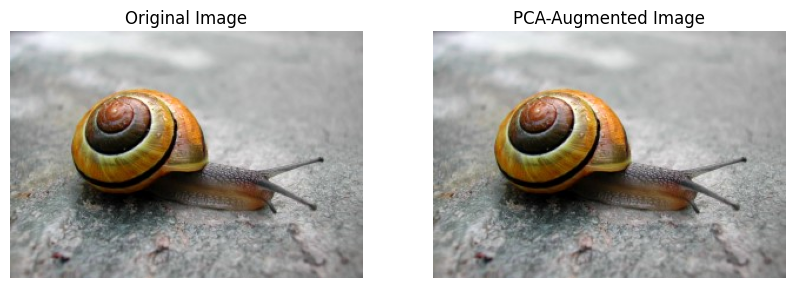

In [49]:
plt.figure(figsize=(10, 5))

# og img
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(testimage)
plt.axis("off")

# augmented img
plt.subplot(1, 2, 2)
plt.title("PCA-Augmented Image")
plt.imshow(augmented_img)
plt.axis("off")

plt.show()

In [51]:
set_seed(42)
data_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Lambda(lambda img: pca_clr_augmentation(img, alpha=0.5)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

## DATA LOADING AND PREP

In [52]:
import os
import shutil

dataset_path = 'binaryinsects'

if os.path.exists(os.path.join(dataset_path, '.ipynb_checkpoints')):
    shutil.rmtree(os.path.join(dataset_path, '.ipynb_checkpoints'))

dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

In [53]:
dataset

Dataset ImageFolder
    Number of datapoints: 934
    Root location: binaryinsects
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               Lambda()
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [54]:
dataset.classes

['catterpillar', 'snail']

In [55]:
len(dataset.classes)

2

In [56]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [57]:
set_seed(42)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [58]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [59]:
for images, labels in train_loader:
    print(labels)
    break


tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0])


In [60]:
v=0
for images, labels in train_loader:
    print(images.shape)
    break


torch.Size([64, 3, 224, 224])


## ALEXNET ARCHITECTURE DEFINITION

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [63]:
set_seed(42)
class AlexNet(nn.Module):
    def __init__(self, classes = 2):
        super(AlexNet, self).__init__()

        # layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        self.localresponsenorm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.localresponsenorm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(in_features=9216, out_features=4096) # 6 x 6 x 256 = 9216 (flatenned output of last max pool layer)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=classes)

        self.drop = nn.Dropout(p=0.7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.localresponsenorm1(x)
        x = self.mpool1(x)
        x = F.relu(self.conv2(x))
        x = self.localresponsenorm2(x)
        x = self.mpool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool3(x)

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x= self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        #x = F.softmax(x, dim=1) # commented out bcz pytorch's crossentropyloss function already takes the log probs

        return x




In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [65]:
set_seed(42)
model = AlexNet().to(device=device)

In [66]:
import torch.optim as optim

In [67]:
set_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [68]:
len(train_loader)

12

In [70]:
set_seed(42)
no_of_epochs = 20
for epoch in range(no_of_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{no_of_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.6922
Epoch [2/20], Loss: 0.6877
Epoch [3/20], Loss: 0.6768
Epoch [4/20], Loss: 0.6609
Epoch [5/20], Loss: 0.6207
Epoch [6/20], Loss: 0.5588
Epoch [7/20], Loss: 0.5370
Epoch [8/20], Loss: 0.4940
Epoch [9/20], Loss: 0.4926
Epoch [10/20], Loss: 0.4429
Epoch [11/20], Loss: 0.4337
Epoch [12/20], Loss: 0.4117
Epoch [13/20], Loss: 0.4340
Epoch [14/20], Loss: 0.3593
Epoch [15/20], Loss: 0.3808
Epoch [16/20], Loss: 0.3647
Epoch [17/20], Loss: 0.3309
Epoch [18/20], Loss: 0.2732
Epoch [19/20], Loss: 0.3284
Epoch [20/20], Loss: 0.2962


In [73]:
set_seed(42)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

Accuracy on test set: 79.67914438502673%


In [77]:
set_seed(42)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on validation set: {accuracy:.2f}%')


Accuracy on validation set: 79.68%


In [78]:

import torch

torch.save(model.state_dict(), 'alexnet.pth')


![snail](https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcR8tc_hxqAAcF21l8n3uxCOYRGsMoPdoVJELaT5aeIg8ctBYYaQnMOjEyG7Zrzb1T_8rQNGDOQoGvPN4BYJtFX5qQ)

In [80]:
# making pred on single image
model = AlexNet().to(device)
model.load_state_dict(torch.load('/content/alexnet.pth'))
model.eval()

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = '/content/images.jpg'
image = Image.open(image_path)
image = data_transforms(image).unsqueeze(0)
image = image.to(device)  # Add a batch dimension

# Make the prediction
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

class_names = ['catterpillar', 'snail']
predicted_class = class_names[predicted.item()]

print(f"The predicted class for the image is: {predicted_class}")

<ipython-input-80-447c8a6bdb84>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/alexnet.pth'))


The predicted class for the image is: snail


![caterpillar](https://5.imimg.com/data5/SELLER/Default/2023/4/302463619/BN/WM/RV/11076359/caterpillar-insect-services.jpeg)


In [85]:
another_image = Image.open('/content/caterpillar-insect-services.jpg')
another_image = data_transforms(another_image).unsqueeze(0)
another_image = another_image.to(device)

with torch.no_grad():
    outputs = model(another_image)
    _, predicted = torch.max(outputs, 1)

predicted_class = class_names[predicted.item()]

print(f"The predicted class for the image is: {predicted_class}")

The predicted class for the image is: catterpillar
